In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

import src.convert_cxx_2_pyfloats as cxx2py
import src.thermodynamic_eqns as thermoeqns
import src.generic_axfuncs as axfuncs
import src.csvdata_2_nparrays as csvdata
import src.findvals as findvals
import src.plot_kinetics as plot_kinetics
import src.plot_radiigrowth as plot_radiigrowth
from src.CommonSuperdropProperties import CommonSuperdropProperties 

# import src.volexponential as volexp
# import src.lognormal as lognorm
# import src.plot_lnRdistrib as pltlnr

sol_filename = "../build/sol.csv"
SDsol_filename = "../build/solSD.csv"
setup_filename = "../build/sol_setup.txt"

is_print = False #print out information about imported constants, data etc.

savedir = "./ipynbplots/"

In [2]:
### read in constants and intial setup from setup .txt file
CONSTS = cxx2py.read_cpp_into_floats(setup_filename, is_print=is_print)[0]
INITS   = cxx2py.inits_dict(CONSTS, is_print=is_print)
MCONSTS = cxx2py.mconsts_dict(CONSTS, is_print=is_print)
nsupers    = int(INITS["nsupers"])                  
VOL = INITS["DROPVOL"]                        


In [3]:
#### Get data and Re-Dimensionalise Solution ###
SDprops = CommonSuperdropProperties(nsupers, VOL, 
              CONSTS["RHO_L"], CONSTS["RHO_SOL"], 
                CONSTS["MR_SOL"], CONSTS["IONIC"])
if is_print:
  SDprops.print_properties()
t, p, temp, qv, qc = csvdata.get_soldata(sol_filename, 
                        CONSTS["TIME0"], CONSTS["P0"], 
                          CONSTS["TEMP0"], is_print=is_print) 
eps, r, m_sol = csvdata.get_SDdata(SDsol_filename, nsupers, 
                  CONSTS["R0"], MCONSTS["RHO0"], is_print=is_print) 
z = t*INITS["iW"]

In [4]:

### Some derived quantities
theta = thermoeqns.dry_pot_temp(temp, p, qv, CONSTS, MCONSTS)        # parcel potential temp
dry_adia, dry_adia_theta = thermoeqns.dry_adiabat(p, temp, CONSTS, MCONSTS)  # dry adiabat given pressure profile 
pv = thermoeqns.vapour_pressure(p, qv, MCONSTS["Mr_ratio"])
psat = thermoeqns.saturation_pressure(temp)
relh, s = thermoeqns.relative_humidity(p, temp, qv, MCONSTS)         # relative humidty and supersaturation
 

### cloud base and max supersaturation
basei, base_sat, base_height = findvals.index_and_value(0, s, z)
maxi, maxsat, maxsat_height = findvals.index_and_value(np.amax(s), s, z)
print('\ncloud base (s=0) at {:.2f}m, s = {:.4f}'.format(base_height, s[basei]))
print('cloud max supersat at {:.2f}m, s = {:.4f}'.format(maxsat_height, s[maxi]))
print('cloud max supersat is {:.2f}m above base\n'.format(maxsat_height-base_height))  




cloud base (s=0) at 840.00m, s = -0.0042
cloud max supersat at 2000.00m, s = 1.1212
cloud max supersat is 1160.00m above base



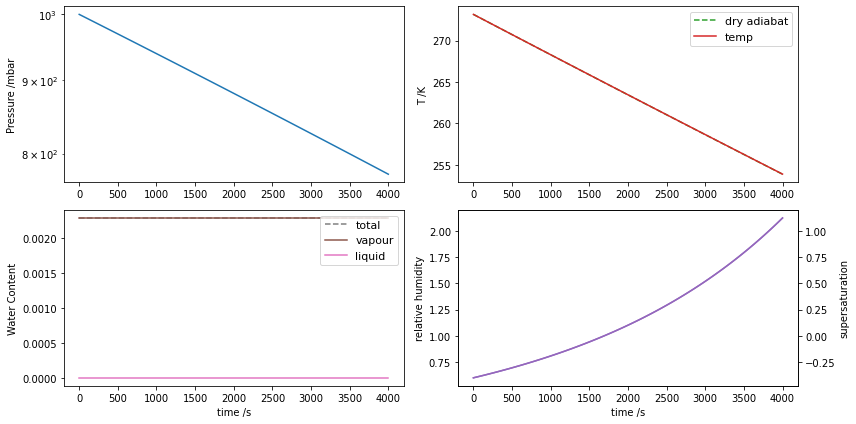

In [5]:
# plots of time evolution of water as parcel rises
fig, axs = plot_kinetics.plot_kinetics_against_time(t, p, temp, qv, qc, 
      relh, s, dry_adia, is_show=True)
#save_figure(savedir, "kinetics_vs_time.png")

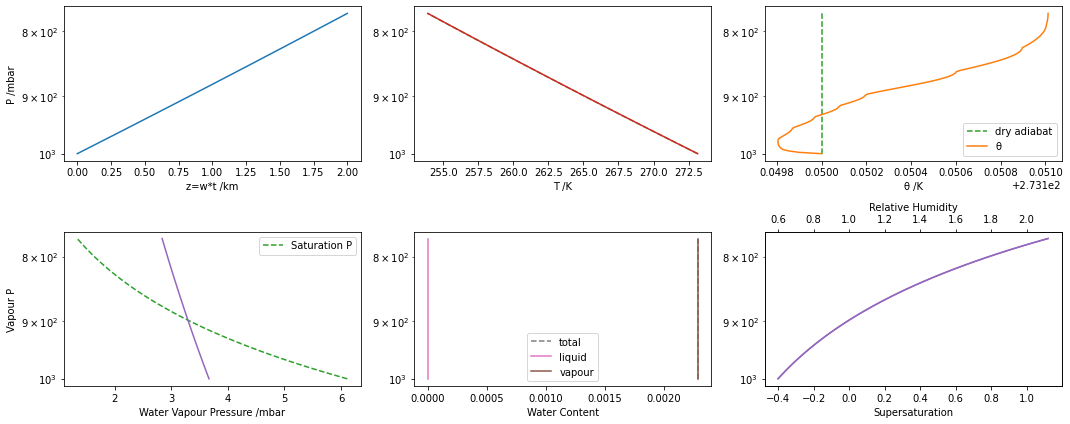

In [6]:
fig, axs = plot_kinetics.plot_kinetics_against_pressure(z, p, temp, qv, qc, 
      theta, pv, psat, relh, s, dry_adia, dry_adia_theta, is_show=True)
#save_figure(savedir, "kinetics_vs_pressure.png")

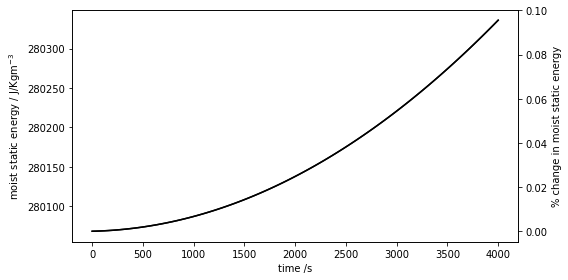

In [7]:
### Moist Static Energy Conservation
mse = thermoeqns.moist_static_energy(z, temp, qv, CONSTS)
fig, ax = plot_kinetics.plot_moist_static_energy(t, mse, is_show=True)
#save_figure(savedir, "moist_static_energy.png")

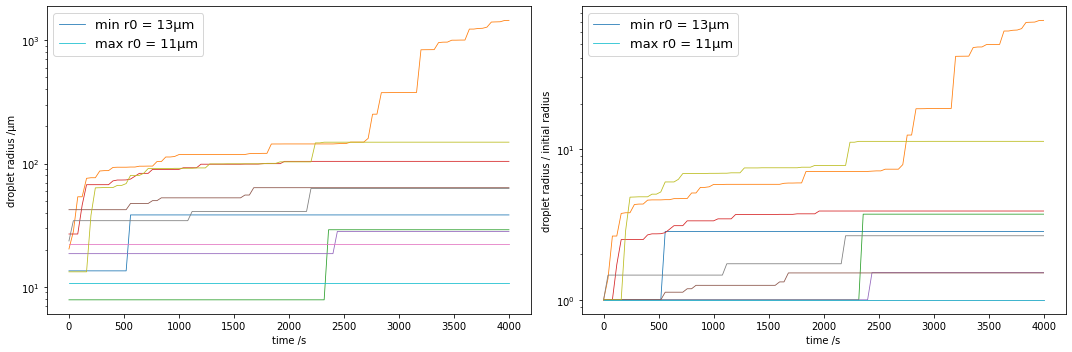

In [8]:
ndrops2plot = 10 # number of individual droplets to plot
fig, axs = plot_radiigrowth.plot_ndrops_individual_growths(t, r, ndrops2plot, is_show=True)
#save_figure(savedir, "SDradiigrowth.png")

IndexError: list index out of range

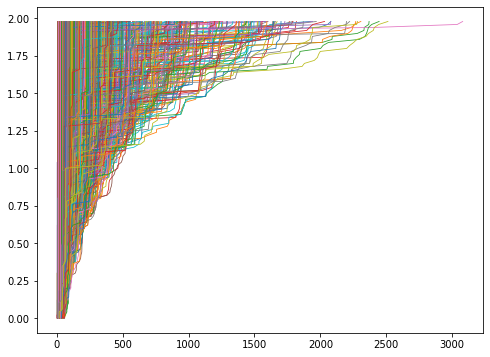

In [9]:
lim1 = 0#basei-10
lim2 = -1#np.argmin(abs(z-cloud_base-400))
### plots of droplet radii growth
fig, ax = plt.subplots(figsize=(8,6))
labs = ['{:.2g}\u03BCm'.format(r*1e6) for r in r[:,0]]
for i in range(nsupers):
    label = None
    if i == 0:
        label = 'min r0 = '+labs[i]
    elif i == nsupers-1:
        label = 'max r0 = '+labs[i]
    ax.plot((r[:,i]*1e6)[lim1:lim2], z[lim1:lim2]/1000, linewidth=0.8, label=label)

axb = ax.twiny()
axb.plot(s[lim1:lim2], z[lim1:lim2]/1000, 
         linewidth=1.5, color='k', label='s')
axb.hlines(z[basei]/1000, np.amin(s[lim1:lim2]), np.amax(s[lim1:lim2]), 
         color='gray', linestyle='--', label='cloud base')

ax.set_ylabel('height, z /km')
ax.set_xlabel('droplet radius /\u03BCm')
axb.set_xlabel('supersaturation, s')
ax.set_xscale('log')
ax.legend(fontsize=13, loc='upper left')
axb.legend(fontsize=13,  loc='upper right')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(9,5))
nplts = 10
nbins = 200
rspan = [np.amin(r), np.amax(r)]
tplt = np.linspace(t[0], t[-1], nplts)
#tplt = np.linspace(1650, 1750, nplts)
linear_twinax(ax, np.log(r[0,:]), eps[0,:]/VOL)
for i in range(nplts):
    ind = np.argmin(abs(t-tplt[i]))
    tlab = 't = {:.2f}s'.format(t[ind])
    c = 'C'+str(i)
    logr_distribution(rspan, nbins, r[ind,:], eps[ind,:]/VOL, ax=ax,
        step=True, lab=tlab, c='C'+str(i), ylab="Real Droplet Conc. /m$^{-3}$")
#ax.set_yscale('log')
ax.legend()
plt.tight_layout()

In [ ]:
nplts = 10
nbins = 200
rspan = [np.amin(r), np.amax(r)]
tplt = np.linspace(t[0], t[-1], nplts)
#tplt = np.linspace(1650, 1750, nplts)
ncols = 5
hist0, hedgs0 = logr_distribution(rspan, nbins, r[0,:], eps[0,:]/VOL)

gd = dict(width_ratios=[1]*ncols, height_ratios=[8,2,1,8,2],)
fig, axs = plt.subplots(ncols=5, nrows=5, 
            figsize=(20,12), gridspec_kw=gd, sharex=True)


def histogram_subplot(axa, tplt, c, rspan, nbins, t, r, eps):   
    
    ind = np.argmin(abs(t-tplt))
    tlab = 't = {:.2f}s'.format(t[ind])
    hist, hedgs = logr_distribution(rspan, nbins, r[ind,:], eps[ind,:]/VOL, ax=axa,
        lab=tlab, c=c, ylab="Real Droplet Conc. /m$^{-3}$")
    axa.set_yscale('log') 
    axa.set_xlabel(None)
    
    return hist, hedgs


def barchart_subplot(axa, axb, cens, bars, wdths, rspan, c):
    
    axb.bar(cens+np.log(1e6), bars, wdths, color=c) 
    axb.hlines(0, np.log(rspan[0])+np.log(1e6),
                        np.log(rspan[-1])+np.log(1e6), linestyle='--', linewidth=0.8)
    axb.set_xlabel('ln(r /\u03BCm)')
    axb.set_ylabel('\u0394')

for ax in axs[2,:]:
    ax.set_axis_off()

i = 0
ylimsa = [np.amin(hist0[hist0!=0]), np.amax(hist0)]
for rw in [0,3]:
    for col in range(ncols):
        axa = axs[rw, col]
        axb = axs[rw+1, col]

        hist, hedgs = histogram_subplot(axa, tplt[i], 
                    'C'+str(i), rspan, nbins, t, r, eps) 
        linear_twinax(axa, np.log(r[0,:]), eps[0,:])
        
        hcens = (hedgs[1:]+hedgs[:-1])/2                     
        hwdths = hedgs[1:]- hedgs[:-1]                                         
        barchart_subplot(axa, axb, hcens, hist-hist0, hwdths, rspan, 'C'+str(i))
        
        if np.amin(hist) < ylimsa[0]:
            ylimsa[0] = np.amin(hist[hist!=0])
        if np.amax(hist) > ylimsa[1]:
            ylimsa[1] = np.amax(hist)
        
        i+=1

for rw in [0,3]:
    for col in range(ncols):
        axs[rw, col].set_ylim(ylimsa)
#         axs[rw, col].set_yscale("linear")
    

plt.tight_layout()
#plt.savefig(savedir+"SDdistribution.png", dpi=400, bbox_inches="tight", facecolor='w')

In [ ]:
### plots of droplet epsilon changes
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
labs = ['{:.2g}\u03BCm'.format(r*1e6) for r in r[:,0]]
for i in range(nsupers):
    label = None
    if i == 0:
        label = 'min r0 = '+labs[i]
    elif i == nsupers-1:
        label = 'max r0 = '+labs[i]
    ax1.plot(t, eps[:,i], linewidth=0.8, label=label)
ax1.set_xlabel('time /s')
ax1.set_ylabel('Multiplicity')
#ax1.set_yscale('log')
ax1.legend(fontsize=13)

for i in range(nsupers):    
    label = None
    if i == 0:
        label = 'min r0 = '+labs[i]
    elif i == nsupers-1:
        label = 'max r0 = '+labs[i]
    ax2.plot(t, eps[:,i]/eps[0,i], linewidth=0.8, label=label) #,color=cols[i])

ax2.set_xlabel('time /s')
ax2.set_ylabel('Multiplicity / initial')
#ax2.set_yscale('log')
ax2.legend(fontsize=13)

plt.tight_layout()
plt.show()